# Tensorflow implementation of "A Neural Algorithm of Artistic Style" by Gatys et al.

Step 0: Load Python libraries and all created libraries for using VGG, calculating loss, performing style transfer, and utility functions

In [1]:
from vggnet import VGG
from utils import *
from loss import total_loss
import matplotlib.pyplot as plt
import tensorflow as tf
import time

%load_ext autoreload
%autoreload 2

Step 1: Load style and content images that will be the target during training

In [2]:
img = {
    'content' : 'tuebingen_neckarfront.jpg',
    'style' : 'starry-night-van-gogh.jpg',
    'result' : 'tuebingen_starry.jpg'
}

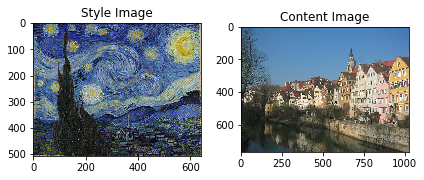

In [3]:
style_im = load_image('../Images/Style/'+img['style'])
content_im = load_image('../Images/Content/'+img['content'])

plt.figure()
plt.subplot(121)
plt.imshow(np.squeeze(style_im).astype('uint8'))
plt.title('Style Image')
plt.subplot(122)
plt.imshow(np.squeeze(content_im).astype('uint8'))
plt.title('Content Image')
plt.tight_layout()
plt.show()

Step 2: Load pre-trained VGG, pre-process style and content images, and define the content features and style features that will be used to calculate loss during "training"

In [4]:
# Load VGG model
vgg = VGG('imagenet-vgg-verydeep-19.mat')

# Preprocess training images
style_im = vgg.preprocess(style_im)
content_im = vgg.preprocess(content_im)

# Define which layer features to use
style_layer = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
content_layer = ['conv4_2']

# Compute style and content features for style and content images respectively
style_net = vgg.net(style_im)
style_feats = []
for layer in style_layer:
    style_feats.append(style_net[layer])

content_net = vgg.net(content_im)
content_feats = []
for layer in content_layer:
    content_feats.append(content_net[layer])
    
# Delete nets to recover memory
del style_net, content_net

Step 3: Define the loss function using a placeholder for the input to VGG. This placeholder will be fed with the target image that will converge to have the content and style of the predefined images. Then, perform style transfer by backpropping the loss into the target image

In [5]:
# DEFINE HYPERPARAMETERS
lr = 1e1
train_iters = 200
checkpoint_iters = 20
content_weight = 1e-3
style_weight = 1
tv_weight = 1

# Define target image that will be modified during train
# Start with content image (instead of noise) to speed up convergence
target_im = tf.Variable(content_im)

# Define target image VGG
target_net = vgg.net(target_im)

print('Target complete')

# Define total loss
loss = total_loss(target_im = target_im,
                  content_shape = content_im.shape,
                  tv_weight = tv_weight,
                  target_net = target_net,
                  style_layer = style_layer,
                  style_feats = style_feats,
                  style_weight = style_weight,
                  content_layer = content_layer,
                  content_feats = content_feats,
                  content_weight = content_weight)

print('Loss complete')

# Define optimizer
train_step = tf.train.AdamOptimizer(lr).minimize(loss)

print('Optimizer complete')

# Initialize bests
best_loss = float('Inf')
best_im = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('Training started')
    for ii in range(train_iters):
        t = time.time()
        
        train_step.run()
        
        if ii % checkpoint_iters == 0 or ii == train_iters-1:
            current_loss = loss.eval()
            print('Current Loss: {}'.format(current_loss))
            
        if current_loss < best_loss:
            best_loss = current_loss
            best_im = target_im.eval()
            print('New best!')
            
            imsave('../Images/Results/'+img['result'], vgg.unprocess(np.squeeze(best_im)))
        
        print('Time elapsed for iteration {}/{}: {}'.format(ii+1, train_iters, time.time()-t))
        
    print('Training complete')

Target complete
Loss complete
Optimizer complete
Training started
Current Loss: 133054.94563888683
New best!
Time elapsed for iteration 1/200: 48.40261769294739
Time elapsed for iteration 2/200: 3.0666863918304443
Time elapsed for iteration 3/200: 3.0704240798950195
Time elapsed for iteration 4/200: 3.078010082244873
Time elapsed for iteration 5/200: 3.0923173427581787
Time elapsed for iteration 6/200: 3.0836451053619385
Time elapsed for iteration 7/200: 3.0883054733276367
Time elapsed for iteration 8/200: 3.1048402786254883
Time elapsed for iteration 9/200: 3.0961971282958984
Time elapsed for iteration 10/200: 3.1145057678222656
Time elapsed for iteration 11/200: 3.1211178302764893
Time elapsed for iteration 12/200: 3.1169400215148926
Time elapsed for iteration 13/200: 3.126495838165283
Time elapsed for iteration 14/200: 3.1157031059265137
Time elapsed for iteration 15/200: 3.12929368019104
Time elapsed for iteration 16/200: 3.137485980987549
Time elapsed for iteration 17/200: 3.15295

Time elapsed for iteration 146/200: 3.1418049335479736
Time elapsed for iteration 147/200: 3.131861925125122
Time elapsed for iteration 148/200: 3.1372475624084473
Time elapsed for iteration 149/200: 3.1416571140289307
Time elapsed for iteration 150/200: 3.151275157928467
Time elapsed for iteration 151/200: 3.1411194801330566
Time elapsed for iteration 152/200: 3.1393935680389404
Time elapsed for iteration 153/200: 3.148981809616089
Time elapsed for iteration 154/200: 3.1430299282073975
Time elapsed for iteration 155/200: 3.142462730407715
Time elapsed for iteration 156/200: 3.1404552459716797
Time elapsed for iteration 157/200: 3.1533989906311035
Time elapsed for iteration 158/200: 3.145557403564453
Time elapsed for iteration 159/200: 3.13637113571167
Time elapsed for iteration 160/200: 3.1501922607421875
Current Loss: 601.1054751011602
New best!
Time elapsed for iteration 161/200: 5.243201732635498
Time elapsed for iteration 162/200: 3.1395926475524902
Time elapsed for iteration 163/

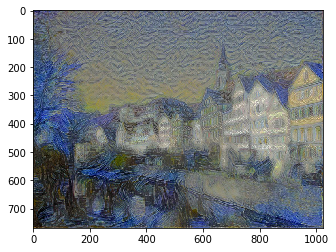

In [6]:
plt.figure()
plt.imshow(np.squeeze(load_image('../Images/Results/'+img['result'])).astype('uint8'))